# Learn the basics of blochK --- A python package to implement Bloch Hamiltonians and compute any observable.

A fermionic tight binding Hamiltonian in momentum space reads 

$H = \sum_{\vec{k}} \vec{\Psi}(\vec{k})^\dagger \cdot h(\vec{k}) \cdot \vec{\Psi}(\vec{k})$

where $\vec{k}$ is 2D momentum (at the moment blochK does not support 3D momenta because I never needed it.) and $\vec{\Psi}$ a $n$-dimensional vector of fermionic annihilation operators in orbital space. Here, orbital space refers to all non-continous degrees of freedom of the Hamiltonian, e.g. spin, sublattice, atomic orbitals, or possibly even real-space. The $n\times n$ matrix $h(\vec{k})$ is called the Bloch Hamiltonian. Diagonalizing it is relativley easy, typically $n$ is at the order of 10. However, many (order $100\times 100$) of these matrices need to be diagonalized and one needs to keep track of all the eigenvectors to compute observables. 

BlochK is python based and provides support in 
 - defining the Hamiltonian and diagonalizing it
 - computing challenging observables like conductivity
 - Plotting, especially plotting observables as color schemes of the band structure

In [1]:
%load_ext autoreload
%autoreload 2

from blochK import Hamiltonian2D
import numpy as np
from numpy import pi,cos,sin,exp

import matplotlib.pyplot as plt
import matplotlib

from blochK.plotting.utils import extent #for getting the correct extent

# Defining a Hamiltonian

Let's define a Hamiltonian. Its core structure is a Hamiltonian function which takes kx,ky (ndarray) and maps it to a ndarray with shape (n_orbitals,n_orbitals,*kx.shape). It should be hermitian in the first two axis.

In [2]:
def Hsquare_fct(kx,ky,t=1,mu=-1,m=0): 
    """
    t: NN hopping 
    mu: chemical potential
    m: FM
    """
    Hk = np.zeros((2,2,*kx.shape),dtype=complex) #Basis (up,down)

    #set hamiltonian structure
    Hk[0,0] = -2*t*cos(kx) - 2*t*cos(ky) - mu

    #make hermitian
    Hk[1,0] = np.conjugate(Hk[0,1])

    #spin degenerate
    Hk[1:,1:] = Hk[:1,:1]

    #add magnetization in z direction
    Hk[0,0] -= m
    Hk[1,1] += m

    return Hk

# Define the Hamiltonian as a Hamiltonian2D object
Hsquare = Hamiltonian2D(Hsquare_fct, basis_states=['up','down'], basis=['spin'], n1=np.array([1,0]), n2=np.array([0,1]))
#parameters like basis, basis_states, are optional but recommended for clarity
#n1,n2 define the Brillouin zone

#Hsquare has many parameters derived from the Hamiltonian function
print('number of orbitals: ', Hsquare.n_orbitals)
print('lattice vectors: ', Hsquare.n1, Hsquare.n2)

#You can define operators in which the Hamiltonian lives in
Hsquare.add_operator('spin', np.array([1,-1])) #diagnonal part of sz
print('spin operator: ', Hsquare.operator.spin)
Hsquare.add_operator('spinx', np.array([[0,1],[1,0]])) #spin x operator
print('spinx operator: \n', Hsquare.operator.spinx)


number of orbitals:  2
lattice vectors:  [1 0] [0 1]
spin operator:  [ 1 -1]
spinx operator: 
 [[0 1]
 [1 0]]


The Brillouin zone of the Hamiltonian is defined automatically via n1 and n2

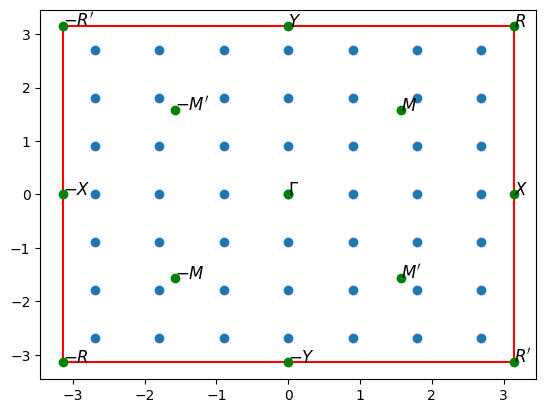

In [3]:
#we can sample the BZ
ks = Hsquare.BZ.sample(7) #sample the BZ with a 7x7 grid
plt.scatter(*ks)

#we can also get the boundary of the BZ
boundary = Hsquare.BZ.return_boundary(periodic=True)
plt.plot(*boundary.T, color='red')

#some high symmetry points which are useful for band structure plots
pts = Hsquare.BZ.points
for l, pt in pts.items():
    plt.plot([pt[0]], [pt[1]], 'go') #mark the point
    plt.text(*pt, r'${}$'.format(l), fontsize=12, ha='left', va='baseline')



# Getting the matrix and diagonalizing it

In [4]:
Hk = Hsquare.evaluate(*ks) #evaluate the Hamiltonian on the k-points
print('shape of Hk: ', Hk.shape) #shape is (n_orbitals, n_orbitals, *kx.shape)
print()

es,psi = Hsquare.diagonalize(*ks) #diagonalize the Hamiltonian
print('shape of es: ', es.shape) #shape is (n_bands, *kx.shape)
print('shape of psi: ', psi.shape) #shape is (n_bands, *kx.shape,n_orbitals, )
print()

#evaluting operators
import blochK.observable as observable
Hsquare.add_operator('project1', np.array([[1,0],[0,0]])) #projector on first basis state
project1 = observable.exp_value_O(Hsquare.operator.project1, psi)
print('shape of project1: ', project1.shape) #shape is (n_bands, n_bands, *kx.shape)
print('momentum sum of projector on first basis state: ', np.sum(project1,axis=(2,3))) #should be number of k-points in the [0.0] element.


shape of Hk:  (2, 2, 7, 7)

shape of es:  (2, 7, 7)
shape of psi:  (2, 7, 7, 2)

shape of project1:  (2, 2, 7, 7)
momentum sum of projector on first basis state:  [[49.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]


# Plotting

## Plotting the FS

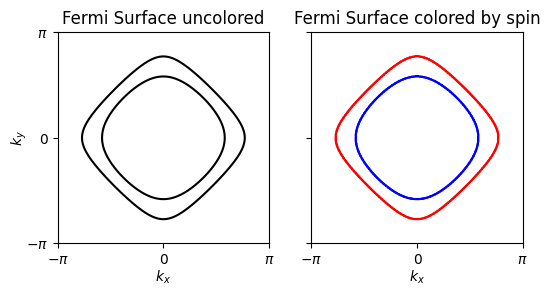

In [5]:
from blochK.plotting import plot_FS

Hsquare.set_params(dict(m=0.5)) #set parameters of Hamiltonian

fig,axs = plt.subplots(1,2, figsize=(6,3))

axs[0].set_title('Fermi Surface uncolored')
plot_FS(axs[0], Hsquare, Lk=100, coloring_operator='k')

axs[1].set_title('Fermi Surface colored by spin')
plot_FS(axs[1], Hsquare, Lk=100, coloring_operator=Hsquare.operator.spin,cmap='bwr',show_ylabel=False)

## Plotting the Band structure

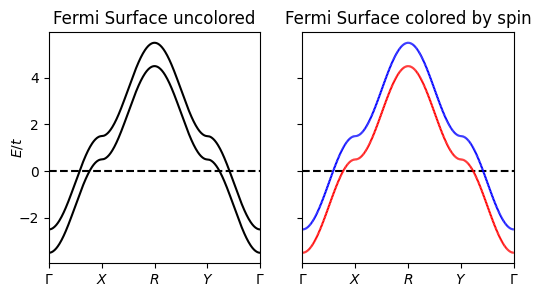

In [6]:
from blochK.plotting import plot_bandstruc


#define a path in the BZ
labels_points_path = ['\Gamma','X','R','Y','\Gamma'] #this is also the default
#the right points are automatically found from the BZ points

fig,axs = plt.subplots(1,2, figsize=(6,3))

axs[0].set_title('Fermi Surface uncolored')
plot_bandstruc(axs[0], Hsquare, N_samples=100, coloring_operator='k')

axs[1].set_title('Fermi Surface colored by spin')
plot_bandstruc(axs[1], Hsquare, N_samples=100,labels_points_path=labels_points_path, coloring_operator=Hsquare.operator.spin,cmap='bwr',show_ylabel=False)

# Computing observables

## Conductivity

The conductivity tensor

$\sigma_{bc}^a/e = \frac{1}{\pi V}\mathrm{Re} \sum_{\vec{k},m,n} \frac{\langle u_n(\vec{k})| J^a_b |u_m(\vec{k})\rangle \langle u_m(\vec{k})| v_c | u_n(\vec{k})\rangle \Gamma^2}{\left(\epsilon_n(\vec{k})^2 + \Gamma^2\right) \left(\epsilon_m(\vec{k})^2 + \Gamma^2\right)}$

where the velocity operator is $v_c = \partial H(\vec{k})/\partial k_c$, the current operator is $J^a_b = \{O^a, v_b\}/2$. $V$ 


In [7]:
sigma = observable.conductivity(Hsquare)
print('sigma: \n', sigma)

sigma_spin = observable.conductivity(Hsquare,operator=Hsquare.operator.spin)
print('sigma_spin: \n', sigma_spin)

sigma: 
 [[ 1.79786173e+00 -1.49768648e-17]
 [-1.49768648e-17  1.79786173e+00]]
sigma_spin: 
 [[ 1.88601804e-01 -4.92633961e-18]
 [-4.92633961e-18  1.88601804e-01]]


We can also compute the conductivity orbital resolved. The axis are then (n_orbitals,direction1, direction2).

In [8]:
sigma_tensor = observable.conductivity_orbital_resolved(Hsquare)
print(sigma_tensor.shape)
print("If the first axis is contracted, we get the same results as above.")

print('sigma: \n', np.einsum('mij,m->ij',sigma_tensor,np.ones(2)))
print('sigma_spin: \n', np.einsum('mij,m->ij',sigma_tensor,Hsquare.operator.spin))

(2, 2, 2)
If the first axis is contracted, we get the same results as above.
sigma: 
 [[ 1.79786173e+00 -2.52639404e-17]
 [-2.52639404e-17  1.79786173e+00]]
sigma_spin: 
 [[1.88601804e-01 6.70240217e-18]
 [6.70240217e-18 1.88601804e-01]]


### Advanced conductivity properties

Here is another simple surpising result about conductivity. This is the conductivity of the simplest metal: Square lattice with NN hoping $t$. Scanning through all energies we see the the low energy limit is described by the free theory $\sigma = \frac{\omega}{4\pi\Gamma}$. 

Also the DC conductivity we defined diverges with $\Gamma$ which is sort of weird because it could easily be regularized but okay.

Finally, we can see the effects of choosing imperfect broadening $\Gamma$: Too small values lead to spiky unphysical features and to large values give incorrect results and the band edges. 'find_Gamma' finds the perfect Gamma for given energies for you. Note that sometimes you need to choose a larger value to smear our spiky features. A smaller value is typically not needed.

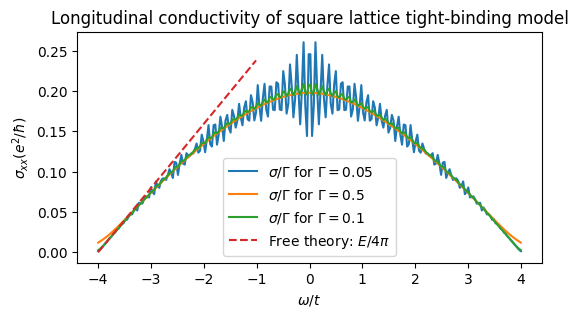

In [150]:
def H0_fct(kx,ky,mu=0):
    """Simple square lattice tight-binding model"""
    Hk = np.zeros((1,1,*kx.shape),dtype=complex) #remember the first 2 indices are for the orbitals
    Hk[0,0] = -2*cos(kx) - 2*cos(ky) - mu
    return Hk

H0 = Hamiltonian2D(H0_fct,param=dict(mu=0,))

fig,ax = plt.subplots(1,1,figsize=(6,3))

es=np.linspace(-4,4,250) #scan the entire bandwidth
for Gamma in [0.05,0.5,0.1]: #0.1 is the optimal value which also find_Gamma finds.
    conds = np.array([observable.conductivity(H0,energy=e,Lk=100,Gamma=Gamma)[0,0] for e in es])
    #the DC conductivity diverges with 1/Gamma
    ax.plot(es,conds*Gamma,'-',label=r'$\sigma/\Gamma$ for $\Gamma={}$'.format(Gamma))

ax.set_xlabel(r'$\omega/t$')
ax.set_ylabel(r'$\sigma_{xx} (e^2/\hbar)$')
ax.set_title('Longitudinal conductivity of square lattice tight-binding model')

xs = es[es<-1]
ax.plot(xs,(xs+4) /4/np.pi,'--', label=r'Free theory: $E/4\pi$')

ax.legend()

## Quasiparticle Interference Pattern

Using 'local_dos_QPI':

We can evaluate the Fourier transform of the local density of states which is probed in STM experiments. For this the single impurity T-matrix approximation is used. 

This assumes a given Hamiltonian + a single impurity term $c^\dagger(r) V(r) c(r) $. Assuming $V(r) = V_0 \delta(r)$, where $V_0$ is hermitian matrix in orbital space the Fourier transformed correction to the local density reads 

$\delta \rho (\vec{q}) = -\frac{1}{\pi} \mathrm{Im Tr} \sum_{\vec{k}} \left(G(\vec{k}+\vec{q}) G(\vec{k}) T \right)$

where $T = (1-V \sum_{\vec{k}} G(\vec{k}))^{-1} V$ and $G(\vec{k}) = \sum_n \frac{|u_n(\vec{k}) \rangle \langle u_n(\vec{k})|}{\epsilon_{\vec{k}} + i \Gamma}$

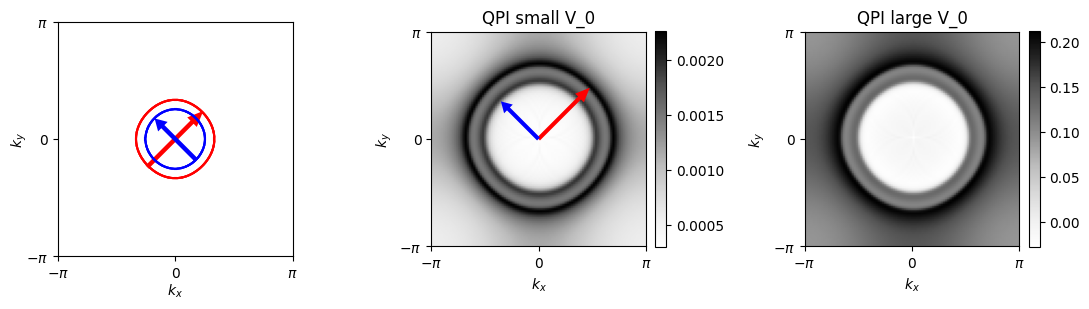

In [9]:
Hsquare.set_params(dict(mu=-3.2,m=0.2)) #set parameters of Hamiltonian
V0 = 0.02 #provide an operator or a float
Lk = 100 #linear BZ slices

ldos = observable.local_dos_QPI(Hsquare, Gamma=0.08,Lk=Lk, operator=V0)

#now plot it

fig, axs = plt.subplots(1,3,figsize=(11,7))
#Born approximation limit
axs[1].set_title('QPI small V_0')
im = axs[1].imshow(ldos,origin='lower',cmap='Greys',extent=extent(Lk))
plt.colorbar(im,ax=axs[1],fraction=0.046,pad=0.04)

#plot the scattering vectors
kF1 = np.array([ 1,1])*0.75
kF2 = np.array([-1,1])*0.55
axs[1].add_patch(matplotlib.patches.Arrow(0,0,*2*kF1,facecolor='r',width=0.6))
axs[1].add_patch(matplotlib.patches.Arrow(0,0,*2*kF2,facecolor='b',width=0.6))


#Bound state limit
V0 = 1.5
axs[2].set_title('QPI large V_0')
ldos = observable.local_dos_QPI(Hsquare, Gamma=0.08,Lk=Lk, operator=V0*np.eye(2))
im = axs[2].imshow(ldos,origin='lower',cmap='Greys',extent=extent(Lk))
plt.colorbar(im,ax=axs[2],fraction=0.046,pad=0.04)#

#plotFS
plot_FS(axs[0],Hsquare,coloring_operator=Hsquare.operator.spin,cmap='bwr')
axs[0].add_patch(matplotlib.patches.Arrow(*(-kF1),*2*kF1,facecolor='r',width=0.6))
axs[0].add_patch(matplotlib.patches.Arrow(*(-kF2),*2*kF2,facecolor='b',width=0.6))

for ax in axs[1:].flatten():
    ax.set_xlabel('$k_x$')
    ax.set_ylabel('$k_y$')
    ax.set_xlim(-pi,pi)
    ax.set_ylim(-pi,pi)
    ax.set_xticks([-pi,0,pi])
    ax.set_yticks([-pi,0,pi])
    ax.set_xticklabels([r'$-\pi$',0,r'$\pi$'])
    ax.set_yticklabels([r'$-\pi$',0,r'$\pi$'])

plt.tight_layout()

## Magnetic linear Dichroism

In a magnetic linear dichroism (MLD) experiment linearly polarized light is shone on the surface of the material which induces optical transitions between the bands at same momenta. The photon (energy $\omega$) scatters an electron from an occupied momentum state at energy $\epsilon_n(\vec{k})$ to an unoccupied momentum state $\epsilon_m(\vec{k})$. Then MLD is then the difference of linearly $x$-polarized and $y$-polarized light.

The single-particle absorption spectrum is

$
I_\alpha(\omega) = \sum_{n,m,\vec{k}} |M^\alpha_{mn}|^2 \delta\left(\epsilon_m(\vec{k}) - \epsilon_n(\vec{k}) - \omega \right) n_{FD}(\epsilon_n(\vec{k})) (1-n_{FD}(\epsilon_m(\vec{k})))
$ 

where $M^\alpha_{mn} = \langle u_m (\vec{k})|v_\alpha | u_n(\vec{k})\rangle$ and $v_\alpha = dH(\vec{k})/dk_\alpha$

Then the MLD is 

$
MLD(\omega) = I_x(\omega) - I_y(\omega)
$

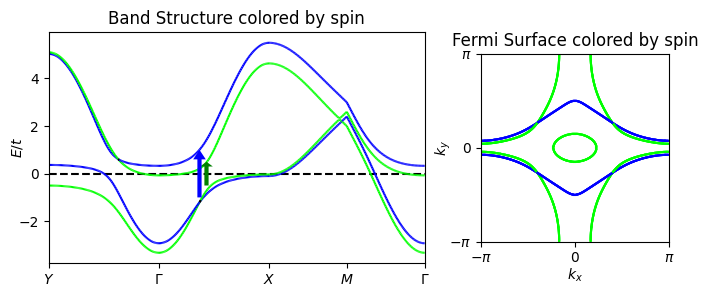

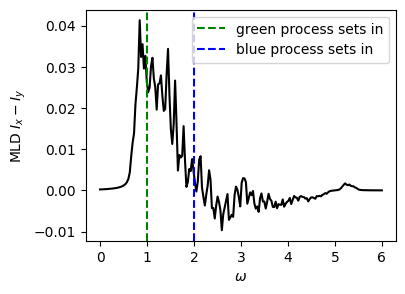

In [10]:
#for this we use a slighly different Hamiltonian, with 2 bands per spin.
import blochK.hamiltonian_testing as hamiltonian_testing
H_wild = Hamiltonian2D(hamiltonian_testing.H_2o_AM_fct,
                       param=dict(t1=1.5,t2=0.5,mu=-2.5,t12=0.4,m_F=0.2,m_AF=0.3),
                       basis_states=['x,up','y,up','x,down','y,down'],
                       basis=['spin','orbital'])
H_wild.add_operator('spin', np.array([1,1,-1,-1])) 

fig,axs = plt.subplots(1,2,gridspec_kw={'width_ratios': [2,1]},figsize=(8,3))
path = ['Y','\Gamma','X','M','\Gamma'] 
axs[0].set_title('Band Structure colored by spin')
axs[1].set_title('Fermi Surface colored by spin')
plot_bandstruc(axs[0], H_wild, N_samples=100, labels_points_path=path, coloring_operator=H_wild.operator.spin)
plot_FS(axs[1], H_wild, coloring_operator=H_wild.operator.spin)
axs[0].add_patch(matplotlib.patches.Arrow(4.5,-0.5,0,1,facecolor='g',width=0.6,zorder=10))
axs[0].add_patch(matplotlib.patches.Arrow(4.3,-1,0,2,facecolor='b',width=0.6,zorder=10))


#compute magnetic linear dichroism which if Matrix elements are unisotropic
omegas = np.linspace(0,6,200)
intensity = observable.magnetic_linear_dichroism(H_wild, omegas) #shape = (n_omegas)

fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(omegas,intensity,'k')
ax.set_xlabel(r'$\omega$')
ax.set_ylabel('MLD $I_x - I_y$')
ax.axvline(1,color='g',ls='--',label=r'green process sets in')
ax.axvline(2,color='b',ls='--',label=r'blue process sets in')
ax.legend()